In [169]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc


In [170]:
def wavelet_hash(image_path, hash_size=128, wavelet='db4', level=1):
    """
    Tính Wavelet perceptual hash.
    
    Args:
        image_path (str): Đường dẫn ảnh
        hash_size (int): Kích thước cạnh ảnh sau resize (mặc định 128 → LL level=1 sẽ là 64x64)
        wavelet (str): Loại wavelet (db4 tốt cho ảnh tự nhiên)
        level (int): Số level decomposition (level=1 là phổ biến nhất)
    
    Returns:
        np.array: Binary hash vector (dtype=uint8)
    """
    # Load và preprocess
    img = Image.open(image_path).convert('L')  # Grayscale
    img = img.resize((hash_size, hash_size), Image.LANCZOS)  # Resize chất lượng cao
    img_array = np.array(img, dtype=np.float32)
    
    # Wavelet decomposition
    coeffs = pywt.wavedec2(img_array, wavelet=wavelet, level=level)
    LL = coeffs[0]  # Approximation coefficients (low-frequency)
    
    # Binary hash dựa trên median của LL band
    median_val = np.median(LL)
    hash_bits = (LL >= median_val).astype(np.uint8)
    
    return hash_bits.flatten()

def hamming_distance(hash1, hash2):
    """Tính Hamming distance và normalized distance"""
    if hash1.shape != hash2.shape:
        raise ValueError("Hash lengths must be equal!")
    distance = np.sum(hash1 != hash2)
    normalized_distance = distance / len

In [171]:
images = [
    #similar images
    "image1.jpg", #original image
    "image2.jpg", #slightly modified image
    "image3.jpg", #noisy image
    "image4.jpg", #blurred image

    #unsimilar images
    "image5.jpg", #cropped image
    "image6.jpg" #rotated image
]

hashes = [wavelet_hash(img) for img in images]

def hamming_distance(hash1, hash2):
    return np.sum(hash1 != hash2)

In [172]:
distances = []
ground_truth = []  # 1 = similar, 0 = unsimilar

for i in range(len(hashes)):
    for j in range(i + 1, len(hashes)):

        d = hamming_distance(hashes[i], hashes[j])
        distances.append(d)

        # gán ground truth dựa trên index
        if i < 4 and j < 4:
            ground_truth.append(1)  # similar
        else:
            ground_truth.append(0)  # unsimilar

        print(f"Distance between {images[i]} and {images[j]}: {d}")


Distance between image1.jpg and image2.jpg: 316
Distance between image1.jpg and image3.jpg: 32
Distance between image1.jpg and image4.jpg: 208
Distance between image1.jpg and image5.jpg: 2448
Distance between image1.jpg and image6.jpg: 2030
Distance between image2.jpg and image3.jpg: 310
Distance between image2.jpg and image4.jpg: 284
Distance between image2.jpg and image5.jpg: 2456
Distance between image2.jpg and image6.jpg: 2032
Distance between image3.jpg and image4.jpg: 204
Distance between image3.jpg and image5.jpg: 2456
Distance between image3.jpg and image6.jpg: 2028
Distance between image4.jpg and image5.jpg: 2462
Distance between image4.jpg and image6.jpg: 2022
Distance between image5.jpg and image6.jpg: 2142


Gaussian blur, Gaussian noise và các phép thay đổi brightness/contrast chủ yếu ảnh hưởng đến các thành phần tần số cao (LH, HL, HH), trong khi không làm thay đổi đáng kể cấu trúc tổng thể của ảnh được biểu diễn ở dải tần số thấp (LL). Do đó, các ảnh tương thích (similar) có Wavelet hash gần nhau và khoảng cách Hamming nhỏ.

Ngược lại, các phép biến đổi hình học như crop hoặc rotate làm thay đổi mạnh cấu trúc không gian toàn cục, dẫn đến sự biến đổi đáng kể ở LL band. Trong phạm vi phương pháp Wavelet hash được sử dụng, các ảnh này được xem là không tương thích (unsimilar) và tạo ra khoảng cách Hamming lớn.

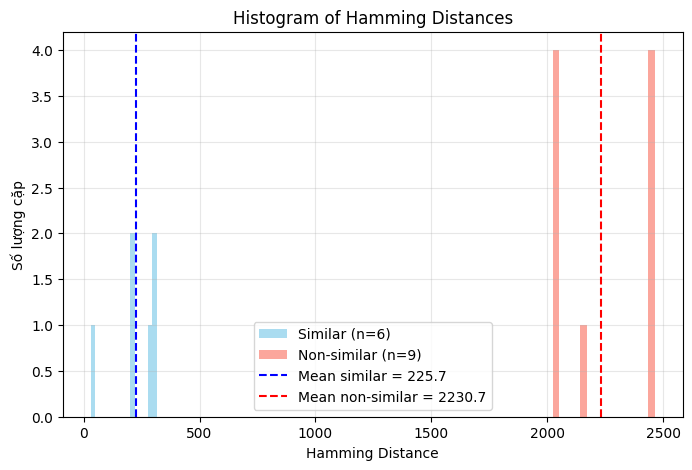

In [173]:
similar_dist = [d for d, gt in zip(distances, ground_truth) if gt == 1]
nonsimilar_dist = [d for d, gt in zip(distances, ground_truth) if gt == 0]

plt.figure(figsize=(8, 5))
plt.hist(similar_dist, bins=15, alpha=0.7, label=f'Similar (n={len(similar_dist)})', color='skyblue')
plt.hist(nonsimilar_dist, bins=15, alpha=0.7, label=f'Non-similar (n={len(nonsimilar_dist)})', color='salmon')
plt.axvline(np.mean(similar_dist), color='blue', linestyle='--', linewidth=1.5,
            label=f'Mean similar = {np.mean(similar_dist):.1f}')
plt.axvline(np.mean(nonsimilar_dist), color='red', linestyle='--', linewidth=1.5,
            label=f'Mean non-similar = {np.mean(nonsimilar_dist):.1f}')
plt.xlabel('Hamming Distance')
plt.ylabel('Số lượng cặp')
plt.title('Histogram of Hamming Distances')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Khảo sát cho thấy sự phân tách rõ ràng giữa hai nhóm ảnh tương thích (similar) và không tương thích (unsimilar).

Khoảng trống (gap) rõ ràng giữa hai phân bố giúp lựa chọn threshold phân loại sao cho không xảy ra chồng lấn giữa hai nhóm.


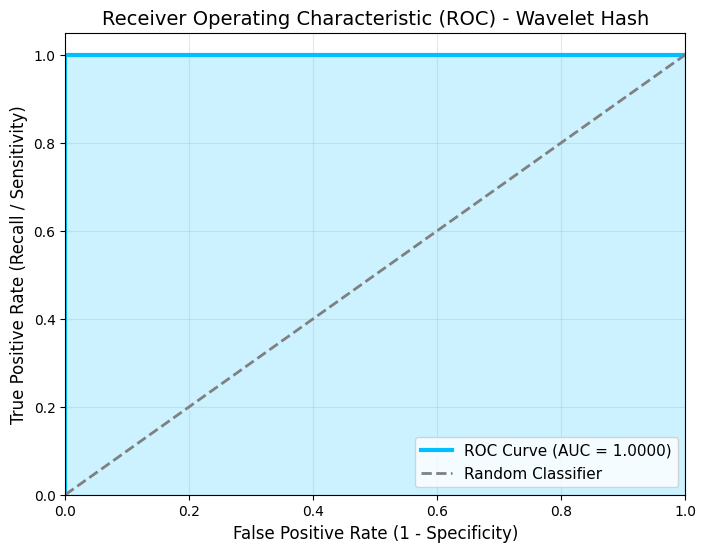

AUC: 1.0000


In [174]:
# Chuẩn bị scores cho ROC: vì Hamming distance càng NHỎ càng similar → cần đảo dấu
scores = [-d for d in distances]

# Tính ROC
fpr, tpr, thresholds_roc = roc_curve(ground_truth, scores)
roc_auc = auc(fpr, tpr)

# Vẽ ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='deepskyblue', lw=3, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Classifier')
plt.fill_between(fpr, tpr, alpha=0.2, color='deepskyblue')  # Tô màu diện tích
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall / Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) - Wavelet Hash', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC: {roc_auc:.4f}")

Đường cong ROC biểu diễn khả năng phân biệt của Wavelet Hash ở mọi ngưỡng threshold có thể.

Với AUC = 1.0000, đường cong ôm sát góc trên-trái, chứng tỏ tồn tại ít nhất một threshold đạt TPR = 1.0 và FPR = 0.0 (phân tách hoàn hảo).

Kết quả này phù hợp với histogram: hai phân bố Hamming distance tách biệt tuyệt đối, không chồng lấn.

In [175]:
# Chọn threshold ở giữa hai mean từ histogram
threshold = (np.mean(similar_dist) + np.mean(nonsimilar_dist)) / 2
print(f"\nThreshold được chọn: {threshold:.2f}")


Threshold được chọn: 1228.17


In [176]:
predictions = [1 if d < threshold else 0 for d in distances]

accuracy = accuracy_score(ground_truth, predictions)
recall = recall_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions)

print("Accuracy:", accuracy)
print("Recall (Độ nhạy):", recall)
print("Precision (Độ đặc hiệu):", precision)


Accuracy: 1.0
Recall (Độ nhạy): 1.0
Precision (Độ đặc hiệu): 1.0


Trong các chỉ số đánh giá nhị phân (Accuracy, Precision, Recall), giá trị nằm trong [0, 1]. Và kết quả cho thấy:
Accuracy: 1.0 -> tất cả nhãn đều được phân loại đúng
Recall: 1.0 -> mọi cặp similar đều được phát hiện, không có false negative
Precision: 1.0 -> mọi cặp được gán similar đều thực sự là similar, không có false positive.

Vì bộ dữ liệu khá đơn giản và số lượng mẫu han chế nên threshold mới phân tách 2 lớp perfectly.
Trường hợp các tập dữ liệu lớn hoặc biến đổi phức tạp, đặc biệt là biến đổi hình học(như crop, rotate..) thì khoảng cách Hamming có thể chồng lấn, dẫn đến việc các chỉ số đánh giá giảm.